In [ ]:
import pandas as pd
import re
import nltk
from nltk import FreqDist
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

nltk.download("stopwords")

In [2]:
df = pd.read_csv("adaKami-reviews.csv")
reviews = df["review"].astype(str).tolist()

In [3]:
stop_words = set(stopwords.words("indonesian"))
custom_stopwords = {"yg", "aja", "dll"}
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words.union(custom_stopwords)]
    tokens = [stemmer.stem(w) for w in tokens]
    return tokens

cleaned_reviews = [clean_text(r) for r in reviews]

In [4]:
w2v_model = Word2Vec(sentences=cleaned_reviews, vector_size=100, window=5, min_count=2, workers=4)

def vectorize(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return sum(vectors)/len(vectors) if vectors else [0]*100

X = [vectorize(tokens) for tokens in cleaned_reviews]

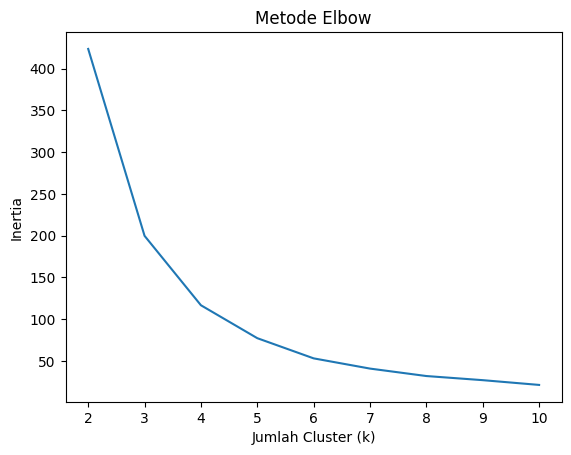

In [15]:
inertia = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K, inertia)
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.title("Metode Elbow")
plt.show()

In [21]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

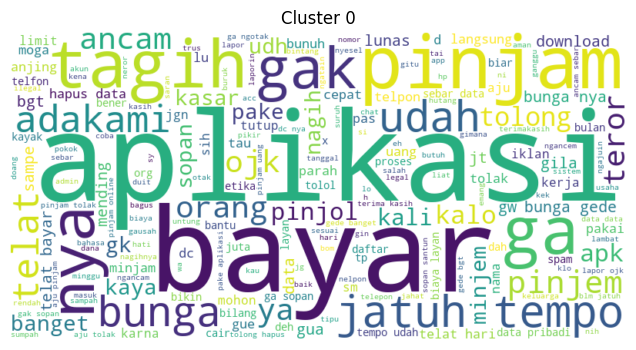

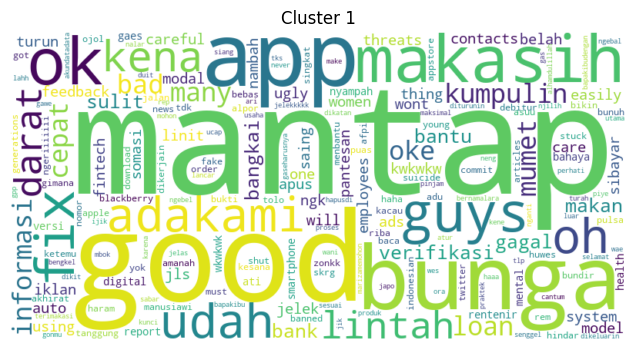

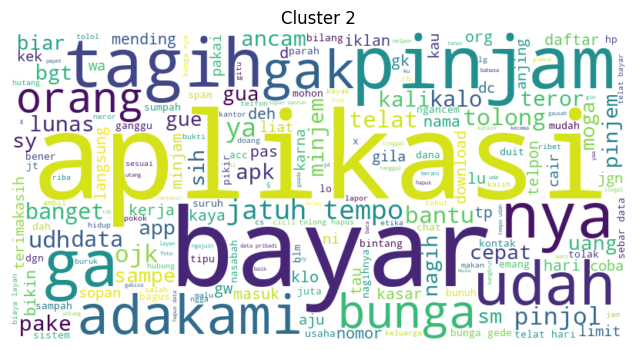

In [22]:
for c in range(k):
    cluster_text = " ".join([" ".join(tokens) for tokens, lbl in zip(cleaned_reviews, labels) if lbl == c])
    if cluster_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_text)
        plt.figure(figsize=(8,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {c}")
        plt.show()

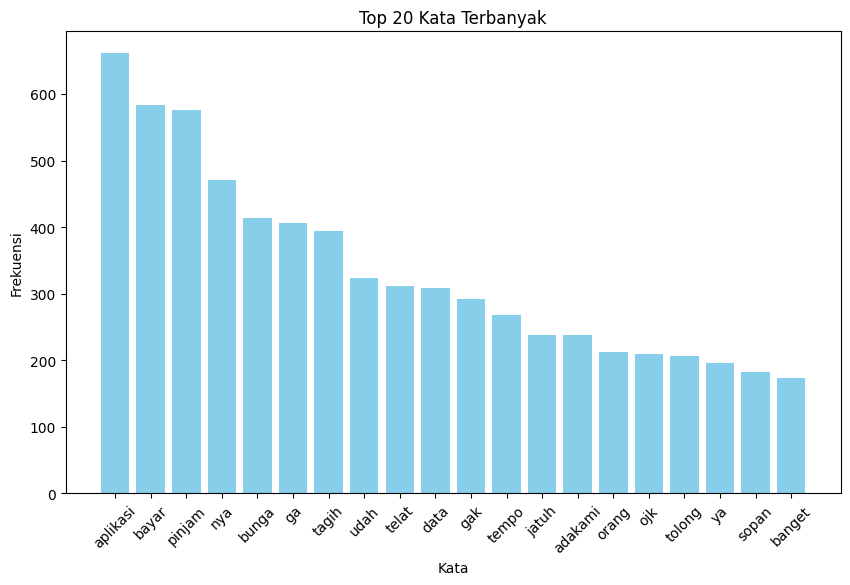

In [23]:
all_tokens = [w for tokens in cleaned_reviews for w in tokens]
freqdist = FreqDist(all_tokens)


common_words = freqdist.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(10,6))
plt.bar(words, counts, color="skyblue")
plt.xticks(rotation=45)
plt.title("Top 20 Kata Terbanyak")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.show()

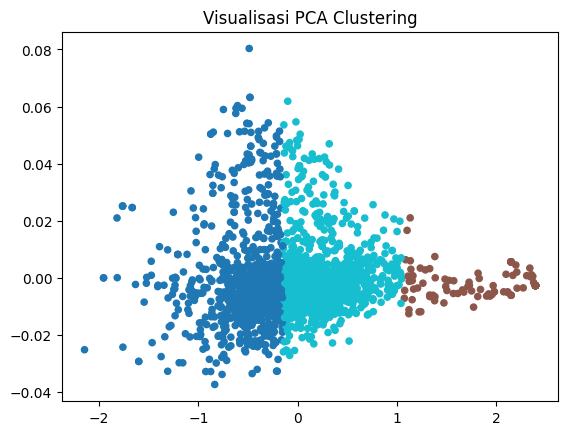

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=20)
plt.title("Visualisasi PCA Clustering")
plt.show()

In [25]:
score = silhouette_score(X, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.5264443402367929
